# Imports

In [0]:
import os
import PIL
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline  
import matplotlib.pyplot as plt
from IPython import display

# Gather Data

In [2]:
# Download the digits data
! wget https://nyc3.digitaloceanspaces.com/ai-classroom/digits.csv

--2020-05-15 00:51:15--  https://nyc3.digitaloceanspaces.com/ai-classroom/digits.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76775041 (73M) [text/csv]
Saving to: ‘digits.csv’

digits.csv          100%[===================>]  73.22M  16.5MB/s    in 5.7s    

2020-05-15 00:51:22 (12.9 MB/s) - ‘digits.csv’ saved [76775041/76775041]



In [3]:
# Take a look at the raw data
! head digits.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

# Pre-process the data

In [4]:
# Read the data into a dataframe
data = pd.read_csv('digits.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Get just the images portions of the data, as that's all we need.
train_images = data[data.columns[1:]].values

In [0]:
# Reshape and normalize the data.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [0]:
# Batch and shuffle the data.
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the models

## The Generator

In [0]:
# make_generator initializes our generator neural network model
def make_generator():

  # In TF 2.0+, "Keras" is the default API. In Keras, you assemble layers to build models.
  # The most common type of model is a stack of layers: the tf.keras.Sequential model.
  model = tf.keras.Sequential()
  
  # Add a dense layer to process the seed/ latent/ random input.
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Start reshaping the data into an image like volume.
  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  # We are then going to use some special convolutional layers. These "transposed"
  # layers can be thought of as a type of "backwards" convolutional layer that is
  # often used to process something that has the shape of the output of some 
  # convolution to something that has the shape of its input.
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [0]:
# Intialize the generator
generator = make_generator()

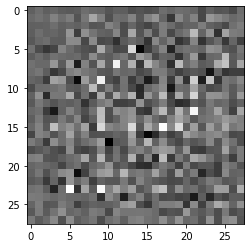

In [10]:
# Let's try using our generator to generate an output from some random input.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [0]:
# make_discriminator initializes our discriminator neural network model
def make_discriminator():

  # In TF 2.0+, "Keras" is the default API. In Keras, you assemble layers to build models.
  # The most common type of model is a stack of layers: the tf.keras.Sequential model.
  model = tf.keras.Sequential()
  
  # Add some typical convolutional layers similar to our other image
  # classification problems. The "Dropout" here is a method that is used to
  # prevent overfitting by randomly dropping out or ignoring the output
  # of some nodes.
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Out dense layer for classification of generated or not generated.
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [0]:
# initialize our discriminator.
discriminator = make_discriminator()

## Define our losses and training related information

In [0]:
# Define cross_entropy loss so that we can utilize it for a custom loss function
# defined below.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# This special loss compares the discriminator's predictions on real images to 
# an array of 1's, and the discriminator's predictions on generated images to an 
# array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# For the generator, we only compare discriminators decisions on the generated 
# images to an array of 1's, because we only care about how well the generator
# did in "fooling" the discriminator.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Use adam optimizers for both models.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# This training is going to run a bit longer, so we are going to save 
# checkpoints. This is a great idea for longer training runs, just in case 
# something goes wrong in the middle.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Define some training parameters.
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Create a particular random seed that we will use over and over during training
# to visualize the output images that are being generated.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train the model

In [0]:
# We are going to define a custom training step for the GAN training. In this 
# case we are going to opt NOT to use eager mode in TensorFlow. Using the
# @tf.function decorator here will cause our computations to be compiled
# into a computational graph before any computations are made. This allows
# the compiler to optimize things and speed up the process. 
@tf.function
def train_step(images):

  # Create random input for our Generator.
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  # As opposed to our examples with PyTorch, we need to implement some special
  # things in TensorFlow to customize our training loop. You can look up these
  # GradientTape related things as you are interested, but they allow us to
  # define this custom training loop.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    # Generate images with the generator.
    generated_images = generator(noise, training=True)

    # Make predictions with the discriminator.
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Calculate our generator and discriminator loss.
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calculate gradients.
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Update our parameters.
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
# generate_and_save_images will help us save generated images so that we can
# view results in a convenient way.
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
# train leverages our custom training step to train our GAN.
def train(dataset, epochs):

  # loop over epochs
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for an output GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

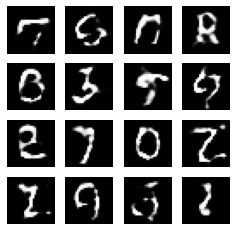

In [20]:
# Let's finally train this thing! As the training occurs, we will occasionally
# print out an example generated image for the same random input.
train(train_dataset, EPOCHS)

# Create a pretty GIF of the generated image at each epoch

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

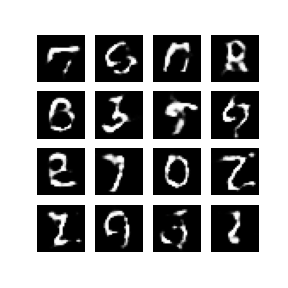

In [22]:
display_image(EPOCHS)

In [0]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)